# Neal's Funnel Target Practice

In [1]:
] activate "./"

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl/examples/LimberJack`


In [2]:
using LinearAlgebra
using Turing
using LimberJack

using GaussianProcess
using CSV
using NPZ
using YAML
using PythonCall
sacc = pyimport("sacc");

using Revise
using MicroCanonicalHMC

In [3]:
sacc_path = "/home/jaimerz/Glamdring/LimberJack.jl/data/FD/cls_FD_covG.fits"
yaml_path = "/home/jaimerz/Glamdring/LimberJack.jl/data/DESY1/gcgc_gcwl_wlwl.yml"
nz_path = "/home/jaimerz/Glamdring/LimberJack.jl/data/DESY1/nzs"
sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)
#nz_DESwl__0 = npzread(string(nz_path, "nz_DESwl__0.npz"))
#nz_DESwl__1 = npzread(string(nz_path, "nz_DESwl__1.npz"))
#nz_DESwl__2 = npzread(string(nz_path, "nz_DESwl__2.npz"))
#nz_DESwl__3 = npzread(string(nz_path, "nz_DESwl__3.npz"))
meta, files = make_data(sacc_file, yaml_file)
                        #nz_DESwl__0=nz_DESwl__0,
                        #nz_DESwl__1=nz_DESwl__1,
                        #nz_DESwl__2=nz_DESwl__2,
                        #nz_DESwl__3=nz_DESwl__3)

cls_data = meta.data
cls_cov = meta.cov

fs8_meta = npzread("/home/jaimerz/Glamdring/LimberJack.jl/data/fs8s/fs8s.npz")
fs8_zs = fs8_meta["z"]
fs8_data = fs8_meta["data"]
fs8_cov = fs8_meta["cov"]

cov = zeros(Float64, length(fs8_data)+length(cls_data), length(fs8_data)+length(cls_data))
cov[1:length(fs8_data), 1:length(fs8_data)] = fs8_cov
cov[length(fs8_data)+1:(length(fs8_data)+length(cls_data)),
    length(fs8_data)+1:(length(fs8_data)+length(cls_data))] = cls_cov
data = [fs8_data; cls_data];

Γ = sqrt(cov)
iΓ = inv(Γ)
data = iΓ * data

n = 101
N = 301
latent_x = range(0., stop=3., length=n)
x = range(0., stop=3., length=N)

fid_cosmo = Cosmology(0.30, 0.05, 0.67, 0.95, 0.81;
    nz_pk=700)
mu = fid_cosmo.Dz(latent_x);

DESgc__0 DESgc__0 5
DESgc__1 DESgc__1 8
DESgc__2 DESgc__2 10
DESgc__3 DESgc__3 11
DESgc__4 DESgc__4 13
DESgc__0 DESwl__0 5
DESgc__0 DESwl__1 5
DESgc__0 DESwl__2 5
DESgc__0 DESwl__3 5
DESgc__1 DESwl__0 8
DESgc__1 DESwl__1 8
DESgc__1 DESwl__2 8
DESgc__1 DESwl__3 8
DESgc__2 DESwl__0 10
DESgc__2 DESwl__1 10
DESgc__2 DESwl__2 10
DESgc__2 DESwl__3 10
DESgc__3 DESwl__0 11
DESgc__3 DESwl__1 11
DESgc__3 DESwl__2 11
DESgc__3 DESwl__3 11
DESgc__4 DESwl__0 13
DESgc__4 DESwl__1 13
DESgc__4 DESwl__2 13
DESgc__4 DESwl__3 13
DESwl__0 DESwl__0 24
DESwl__0 DESwl__1 24
DESwl__0 DESwl__2 24
DESwl__0 DESwl__3 24
DESwl__1 DESwl__1 24
DESwl__1 DESwl__2 24
DESwl__1 DESwl__3 24
DESwl__2 DESwl__2 24
DESwl__2 DESwl__3 24
DESwl__3 DESwl__3 24


In [4]:
init_params_DES=[0.292678, 0.047209, 0.724118, 0.966518,
            1.484146, 1.803888, 1.776368, 2.165838, 2.229292,
            0.003434, 0.003287, 0.001131, 0.002007,-0.001190,
            0.004439,-0.030517, 0.006111,-0.024645,
            0.017999, 0.014482, 0.010009, 0.004870,
            0.0, 0.0];
init_params_DES = [init_params_DES; zeros(101)]

init_params_ND=[0.292678, 0.047209, 0.724118, 0.966518,
            1.484146, 1.803888, 1.776368, 2.165838, 2.229292,
            0.003434, 0.003287, 0.001131, 0.002007,-0.001190,
            0.004439,-0.030517, 0.006111,-0.024645,
            0.017999, 0.014482, 0.010009, 0.004870,
            0.0, 0.0,
            1.8, 2.0]
init_params_ND = [init_params_ND; zeros(101)];

In [5]:
@model function model(data;
    meta=meta,
    files=files)

    #KiDS priors
    Ωm ~ Uniform(0.2, 0.6)
    Ωb ~ Uniform(0.028, 0.065)
    h ~ Truncated(Normal(0.72, 0.05), 0.64, 0.82)
    σ8 = 0.81
    ns ~ Uniform(0.84, 1.1)
    
    DESgc__0_b ~ Uniform(0.8, 3.0)
    DESgc__1_b ~ Uniform(0.8, 3.0)
    DESgc__2_b ~ Uniform(0.8, 3.0)
    DESgc__3_b ~ Uniform(0.8, 3.0)
    DESgc__4_b ~ Uniform(0.8, 3.0)
    DESgc__0_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DESgc__1_dz ~ TruncatedNormal(0.0, 0.007, -0.2, 0.2)
    DESgc__2_dz ~ TruncatedNormal(0.0, 0.006, -0.2, 0.2)
    DESgc__3_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    DESgc__4_dz ~ TruncatedNormal(0.0, 0.01, -0.2, 0.2)
    DESwl__0_dz ~ TruncatedNormal(-0.001, 0.016, -0.2, 0.2)
    DESwl__1_dz ~ TruncatedNormal(-0.019, 0.013, -0.2, 0.2)
    DESwl__2_dz ~ TruncatedNormal(0.009, 0.011, -0.2, 0.2)
    DESwl__3_dz ~ TruncatedNormal(-0.018, 0.022, -0.2, 0.2)
    DESwl__0_m ~ Normal(0.012, 0.023)
    DESwl__1_m ~ Normal(0.012, 0.023)
    DESwl__2_m ~ Normal(0.012, 0.023)
    DESwl__3_m ~ Normal(0.012, 0.023)
    A_IA ~ Uniform(-5, 5) 
    alpha_IA ~ Uniform(-5, 5)

    nuisances = Dict("DESgc__0_b" => DESgc__0_b,
                     "DESgc__1_b" => DESgc__1_b,
                     "DESgc__2_b" => DESgc__2_b,
                     "DESgc__3_b" => DESgc__3_b,
                     "DESgc__4_b" => DESgc__4_b,
                     "DESgc__0_dz" => DESgc__0_dz,
                     "DESgc__1_dz" => DESgc__1_dz,
                     "DESgc__2_dz" => DESgc__2_dz,
                     "DESgc__3_dz" => DESgc__3_dz,
                     "DESgc__4_dz" => DESgc__4_dz,
                     "DESwl__0_dz" => DESwl__0_dz,
                     "DESwl__1_dz" => DESwl__1_dz,
                     "DESwl__2_dz" => DESwl__2_dz,
                     "DESwl__3_dz" => DESwl__3_dz,
                     "DESwl__0_m" => DESwl__0_m,
                     "DESwl__1_m" => DESwl__1_m,
                     "DESwl__2_m" => DESwl__2_m,
                     "DESwl__3_m" => DESwl__3_m,
                     "A_IA" => A_IA,
                     "alpha_IA" => alpha_IA)

    eta = 0.2
    l = 0.3
    v ~ filldist(truncated(Normal(0, 1), -2, 2), n)
    K = sqexp_cov_fn(latent_x; eta=eta, l=l, delta=10^-9)
    latent_gp = latent_GP(mu, v, K)
    gp = conditional(latent_x, x, latent_gp, sqexp_cov_fn;
                    eta=1.0, l=l)
    
    cosmology = Cosmology(Ωm, Ωb, h, ns, σ8,
                          tk_mode="EisHu",
                          Pk_mode="Halofit", 
                          custom_Dz=[x, gp])
    
    cls = Theory(cosmology, meta, files; Nuisances=nuisances)
    fs8s = fs8(cosmology, fs8_zs)
    theory = [fs8s; cls]
    
    data ~ MvNormal(iΓ * theory, I)
end;

In [6]:
# Cond. Model
cond_model = model(data)
target = TuringTarget(cond_model; d=125);

### Sample MCHMC

In [7]:
iterations = 10
adaptation = 300
TEV = 0.1
init_ϵ = 0.03

println("sampling settings: ")
println("iterations ", iterations)
println("TEV ", TEV)
println("adaptation ", adaptation)

# Start sampling.
folpath = "./"
folname = string("DES_RSD_super_gp_TEV_", TEV)
folname = joinpath(folpath, folname)

if isdir(folname)
    fol_files = readdir(folname)
    println("Found existing file ", folname)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("chain", file)])
        last_n = parse(Int, last_chain[end-4])
        #println("Restarting chain")
    else
        #println("Starting new chain")
        last_n = 0
    end
else
    mkdir(folname)
    println(string("Created new folder ", folname))
    last_n = 0
end

# Create a placeholder chain file.
CSV.write(joinpath(folname, string("chain_", last_n+1,".csv")), Dict("params"=>[]), append=true)

# Sample
sampler = MCHMC(0, TEV; eps=0.2, L=0.2*sqrt(125), sigma=ones(125), 
    adaptive=true)
chain = Sample(sampler, target, iterations;
               init_params=init_params_DES, dialog=true)

sampling settings: 
iterations 10
TEV 0.1
adaptation 300
Found existing file ./DES_RSD_super_gp_TEV_0.1


[ Info: using provided init params


[0.42906064995857807, 0.04693660216545009, 0.7612323730053794, 1.0283504785693778, 2.5934355844691708, 2.6889674321252475, 2.6815451772807686, 2.773706967594191, 2.786268407862341, 0.00034339966254245957, 0.000328699704050639, 0.00011309998794395426, 0.00020069993263094332, -0.000118999985957019, 0.0004438992710909806, -0.0030514631879356713, 0.0006110980982475256, -0.0024643752677248054, 0.017999, 0.014482, 0.010009, 0.00487, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


[ Info: eps: 0.2
[ Info: L: 2.23606797749979
[ Info: nu: 0.039586233337038305
[ Info: sigma: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[ Info: adaptive: true


[-1.198764938150285, 0.07668620775213628, -0.1308976937630905, -0.053582046753975, -0.7955629103583128, -0.17519583536683475, -0.2257391997439065, 0.49309581056152546, 0.6176249228500078, 0.0343433751762477, 0.03287295997646681, 0.011310120563237549, 0.020070673731903153, -0.011900140432899574, 0.04439729125991481, -0.30757198562322646, 0.061129028255566605, -0.24770888784507114, 0.017999, 0.014482, 0.010009, 0.00487, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:14

10-element Vector{Any}:
 [-1.198764938150285, 0.07668620775213628, -0.1308976937630905, -0.053582046753975, -0.7955629103583128, -0.17519583536683475, -0.2257391997439065, 0.49309581056152546, 0.6176249228500078, 0.0343433751762477  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0457210094286429, 0.0, -3454.8438794919666]
 [-1.4533604420425403, 0.0461567201245854, -0.14501816093753664, 0.0011054991974912105, -0.8101993952387523, -0.1887713529633433, -0.24741694777256654, 0.4876080812798798, 0.6157197197959594, 0.14065156043008048  …  -4.032649877209448e-6, 2.9844806061871195e-6, 1.4461560548311503e-6, 3.267680325344554e-7, -2.9655120286957802e-6, 4.129350168543684e-7, -4.721711257049837e-6, 0.08815565724122679, -41.28543381396048, -1807.5068851671415]
 [-1.5653640687375563, 0.00844609797209733, -0.15352481019783987, 0.022047091339355382, -0.8173448852756955, -0.19506312758960762, -0.2575581843470614, 0.48505170182137214, 0.6157175038472134, 0.1884350101486441  …  -0.0007351166973204511, 0.000

In [8]:
using Random
println(target.inv_transform(init_params_DES))
transition, state = MicroCanonicalHMC.Step(
        Random.GLOBAL_RNG,
        sampler,
        target.h;
        bijector = target.transform,
        init_params = target.inv_transform(init_params_DES),
    );
println(transition.θ)

[0.42906064995857807, 0.04693660216545009, 0.7612323730053794, 1.0283504785693778, 2.5934355844691708, 2.6889674321252475, 2.6815451772807686, 2.773706967594191, 2.786268407862341, 0.00034339966254245957, 0.000328699704050639, 0.00011309998794395426, 0.00020069993263094332, -0.000118999985957019, 0.0004438992710909806, -0.0030514631879356713, 0.0006110980982475256, -0.0024643752677248054, 0.017999, 0.014482, 0.010009, 0.00487, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.29267800000000016, 0.04720900000000035, 0.724117999

[ Info: eps: 0.1017243784895057
[ Info: L: 2.23606797749979
[ Info: nu: 0.02760472875840767
[ Info: sigma: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[ Info: adaptive: true


In [9]:
state

MicroCanonicalHMC.MCHMCState{Float64}(Random._GLOBAL_RNG(), 0, [0.42906064995857807, 0.04693660216545009, 0.7612323730053794, 1.0283504785693778, 2.5934355844691708, 2.6889674321252475, 2.6815451772807686, 2.773706967594191, 2.786268407862341, 0.00034339966254245957  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.03823961667465078, 0.03358840575690067, -0.07974023221123054, -0.07417982261915208, 0.05896069588118214, 0.07696018756332439, -0.06779491309002886, 0.13330291030062827, -0.07187776091967557, -0.010041706333188415  …  -0.0736869333400444, -0.10295092891506828, 0.11922979376688007, 0.06804812539114673, 0.0055621931856634005, -0.039045236619415835, 0.031050014152750542, -0.10931134944478602, 0.08910696143128452, -0.0957765360518193], 4892.227508700421, [1113.4882607493744, 21.38692186407945, -65.39433400297578, -274.80629650612104, 247.7032083655939, 277.42640264595246, 435.4932621428869, 120.57567870737084, 42.20600692358623, -989.1728751978835  …  -0.01742373244451723

In [10]:
using DelimitedFiles
using Plots

mean deltaE: -3.5369878342321046


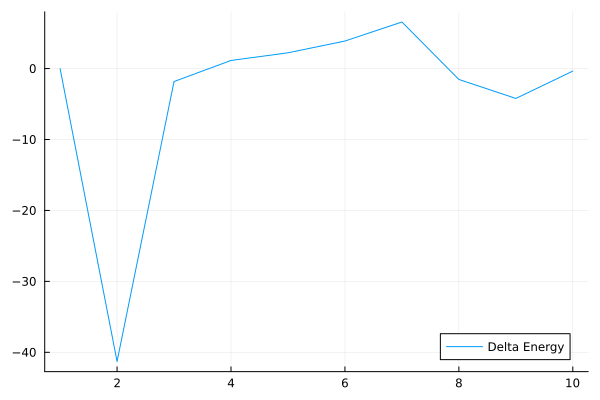

In [11]:
E = [sample[end-1] for sample in chain]
println("mean deltaE: ", mean(E))
plot(E, label="Delta Energy")

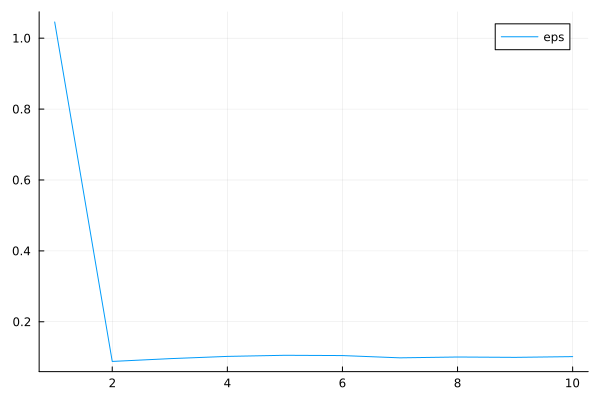

In [12]:
eps = [sample[end-2] for sample in chain]
plot(eps, label="eps")

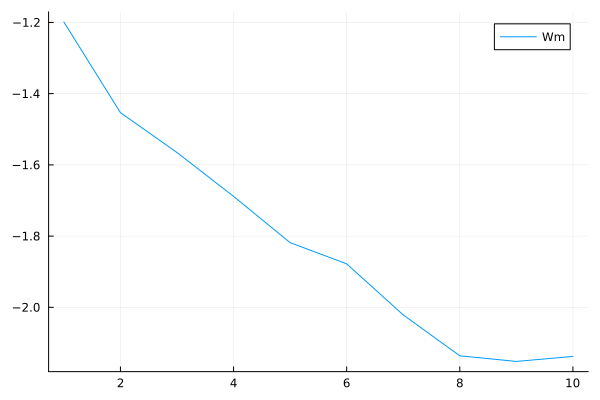

In [13]:
Wm = [sample[1] for sample in chain]
plot(Wm, label="Wm")